In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats

import tensorflow as tf
from tensorflow import keras
models = keras.models
layers = keras.layers
regularizers = keras.regularizers
import os

2025-08-27 09:05:00.101436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-27 09:05:01.355237: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 09:05:02.243536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/software.hpc.rwth.de/Linux/RH9/x86_64/int

In [9]:
for i in range(10000,100000,250):
    if not os.path.exists("/hpcwork/zu992399/look_elsewhere/NN_test/NN_test_kfoldscorrected/kfolds_earlystopping_restore/run"+str(i+246)):
        print(i)

10250
23000
31750
46000
51500
89250
89500
91250
96250


In [2]:
uniform = False

In [5]:

def to_categorical(Y, N_classes=2):
	Y=np.array(Y,dtype=int)
	return np.eye(N_classes)[Y]

def make_model(activation="relu",hidden=3,inputs=4,lr=1e-3,dropout=0.1, l1=0, l2 =0, momentum = 0.9, label_smoothing=0):
	model = models.Sequential()
	model.add(layers.Dense(64,input_shape=(inputs,)))
	for i in range(hidden-1):
		if activation =="relu":
			model.add(layers.ReLU())
		elif activation == "leaky":
			model.add(layers.LeakyReLU(alpha=0.1))
		model.add(layers.Dropout(dropout))
		model.add(layers.Dense(64,kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
		model.add(layers.ReLU())
	model.add(layers.Dense(2, activation="softmax"))

	loss = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

	model.compile(
		loss=loss,
		optimizer=keras.optimizers.Adam(lr, beta_1=momentum),
		metrics=["accuracy"],
	)

	return model

def oned_sample(N, rv):
    x = rv.rvs(N).reshape((N,1))
    y = rv.rvs(N).reshape((N,1))
    return np.concatenate((x,y), axis=1)

if uniform: 
    rv = stats.uniform(loc=-2, scale=4)
else:
	rv = multivariate_normal([0,0], [[1,0],[0,1]])


In [9]:
if uniform:
    data = oned_sample(40000, rv)
else:
    data = rv.rvs(40000)
X_train, X_test =np.array_split(data,2)

Y_train = np.append(np.ones(len(X_train)//2), np.zeros(len(X_train)//2))
np.random.shuffle(Y_train)
Y_train = to_categorical(Y_train)

model = make_model(inputs=2)

results = model.fit(
    X_train,
    Y_train,
    batch_size=1024,
    epochs=500,
    validation_split = 0.5,
    shuffle=True,
    verbose=2,
    )

Epoch 1/500
10/10 - 0s - loss: 0.6943 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5046 - 309ms/epoch - 31ms/step
Epoch 2/500
10/10 - 0s - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4980 - 49ms/epoch - 5ms/step
Epoch 3/500
10/10 - 0s - loss: 0.6928 - accuracy: 0.5104 - val_loss: 0.6940 - val_accuracy: 0.5028 - 94ms/epoch - 9ms/step
Epoch 4/500
10/10 - 0s - loss: 0.6927 - accuracy: 0.5078 - val_loss: 0.6936 - val_accuracy: 0.5039 - 90ms/epoch - 9ms/step
Epoch 5/500
10/10 - 0s - loss: 0.6925 - accuracy: 0.5048 - val_loss: 0.6937 - val_accuracy: 0.5020 - 49ms/epoch - 5ms/step
Epoch 6/500
10/10 - 0s - loss: 0.6925 - accuracy: 0.5071 - val_loss: 0.6936 - val_accuracy: 0.5002 - 69ms/epoch - 7ms/step
Epoch 7/500
10/10 - 0s - loss: 0.6929 - accuracy: 0.5061 - val_loss: 0.6937 - val_accuracy: 0.5011 - 93ms/epoch - 9ms/step
Epoch 8/500
10/10 - 0s - loss: 0.6924 - accuracy: 0.5161 - val_loss: 0.6941 - val_accuracy: 0.5030 - 93ms/epoch - 9ms/step
Epoch 9/500
10

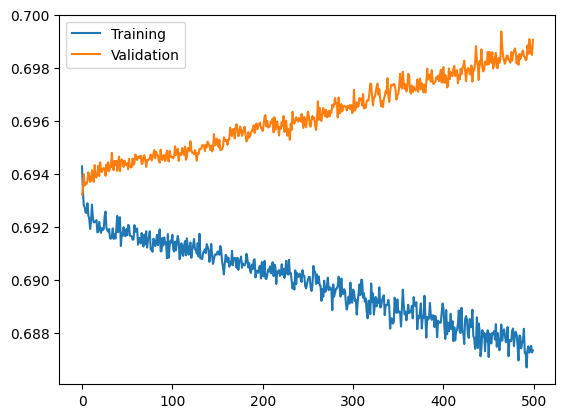

In [10]:
plt.figure()
plt.plot(results.history['loss'], label="Training")
plt.plot(results.history['val_loss'], label="Validation")
plt.legend()